In [29]:
import os, glob, json, math, time, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

# Setting up directories
base = "../data/raw"
ptfe_raw_dir = os.path.join(base, "ptfe")   # 100 CSV for pure PTFE
hbn_raw_dir  = os.path.join(base, "hbn_thin")    # 100 CSV for pure hBN
out_dir = "../generated/grid_100"
os.makedirs(out_dir, exist_ok=True)

# Film physics
t_ptfe_um = 200.0      # PTFE film thickness (µm)
t_hbn_um  = 540.0   # hBN "reference" thickness (µm)  (updated for the thin pellet)
rho_ptfe  = 2.20     # g/cm^3
rho_hbn   = 0.3     # g/cm^3  (updated for the thin pellet)

# "Mix" thickness: we model spectra as if recorded on a PTFE film
t_mix_um = t_ptfe_um

# Dataset/grid settings
N_GRID = 100                    # number of grid slots/files to produce
GRID_HBN_BY_INDEX = {           # explicit mixed slots with %PTFE (index: percent)
    3: 1, 4: 2, 12: 3, 30: 1, 35: 1,
    41: 1, 42: 2, 43: 3, 44: 4, 45: 5,
    50: 6, 55: 7, 60: 8, 70: 9, 80: 10
}
N_RANDOM_MIXED = 15           # additional random mixed slots (0 keeps explicit only)
HBN_MIN, HBN_MAX = 1, 50      # range for random mixed %hBN if used

# When building the bank, we will LSQ-scale each raw to a canonical median
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Config ready.")


Config ready.


In [30]:
# Some untilities
def load_xy_any(fn: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load 2-column CSV (header/no-header tolerant) → (x, y) as float arrays."""
    try:
        df = pd.read_csv(fn, header=0)
        x = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        y = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        if np.isnan(x).any() or np.isnan(y).any(): raise ValueError
    except Exception:
        df = pd.read_csv(fn, header=None)
        x = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        y = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        mask = ~(np.isnan(x) | np.isnan(y)); x,y = x[mask], y[mask]
    return x, y

def build_file_list(folder: str) -> List[str]:
    files = sorted(glob.glob(os.path.join(folder, "*.CSV")))
    if not files:
        files = sorted(glob.glob(os.path.join(folder, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in: {folder}")
    return files

print("Utils ready.")


Utils ready.


In [31]:
ptfe_files = build_file_list(ptfe_raw_dir)
hbn_files  = build_file_list(hbn_raw_dir)
print(f"Found PTFE files: {len(ptfe_files)}, hBN files: {len(hbn_files)}")

# Load all once to determine a common grid
raw_ptfe = [load_xy_any(f) for f in ptfe_files]
raw_hbn  = [load_xy_any(f) for f in hbn_files]

# Determine overlap range across all files (safe/common window)
wn_min = max(min(x.min() for x,_ in raw_ptfe),
             min(x.min() for x,_ in raw_hbn))
wn_max = min(max(x.max() for x,_ in raw_ptfe),
             max(x.max() for x,_ in raw_hbn))

assert wn_max - wn_min > 500, "Common spectral window too small; check raw files."

wn = np.arange(math.ceil(wn_min), math.floor(wn_max)+1, 1.0)  # 1 cm^-1 step

def interp_bank(raw_list):
    bank = []
    for (x,y), fn in zip(raw_list, [*ptfe_files] if raw_list is raw_ptfe else [*hbn_files]):
        yi = np.interp(wn, x, y)
        bank.append({"file": os.path.basename(fn), "A_raw": yi})
    return bank

ptfe_bank = interp_bank(raw_ptfe)
hbn_bank  = interp_bank(raw_hbn)

print("Interpolated to common grid; wn points:", len(wn))


Found PTFE files: 100, hBN files: 100
Interpolated to common grid; wn points: 3323


In [32]:
# Scalling funtions
def lsq_scale_to_ref(A, ref):
    """Return scalar s that minimizes ||s*A - ref||_2."""
    denom = float(np.dot(A, A))
    return float(np.dot(A, ref) / denom) if denom > 0 else 1.0

# Build canonical (median across bank) first pass
ptfe_stack = np.vstack([d["A_raw"] for d in ptfe_bank])
hbn_stack  = np.vstack([d["A_raw"] for d in hbn_bank])
ptfe_med   = np.median(ptfe_stack, axis=0)
hbn_med    = np.median(hbn_stack,  axis=0)

# LSQ-scale each to its canonical median (mitigates intensity offsets)
for d in ptfe_bank:
    s = lsq_scale_to_ref(d["A_raw"], ptfe_med)
    d["scale_to_med"] = s
    d["A_scaled"]     = s * d["A_raw"]

for d in hbn_bank:
    s = lsq_scale_to_ref(d["A_raw"], hbn_med)
    d["scale_to_med"] = s
    d["A_scaled"]     = s * d["A_raw"]

# Recompute canonicals after scaling (optional refinement)
ptfe_stack2 = np.vstack([d["A_scaled"] for d in ptfe_bank])
hbn_stack2  = np.vstack([d["A_scaled"] for d in hbn_bank])
ptfe_ref    = np.median(ptfe_stack2, axis=0)
hbn_ref     = np.median(hbn_stack2,  axis=0)

print("Bank harmonized (scaled to canonical medians).")


Bank harmonized (scaled to canonical medians).


In [33]:
# Convert µm → cm
um_to_cm = 1e-4
t_ptfe_cm = t_ptfe_um * um_to_cm
t_hbn_cm  = t_hbn_um  * um_to_cm
t_mix_cm  = t_mix_um  * um_to_cm

# For each selected spectrum we will use a normalized version:
# A_norm = A_scaled / (rho * t_material_cm)
# Then, to create a film/mix at thickness t_mix_cm with bulk density rho_mix:
# A_out = (w_ptfe * A_ptfe_norm + w_hbn * A_hbn_norm) * (rho_mix * t_mix_cm)
def to_areal_mass_norm(A_scaled, rho, t_cm):
    return A_scaled / (rho * t_cm)

for d in ptfe_bank:
    d["A_norm"] = to_areal_mass_norm(d["A_scaled"], rho_ptfe, t_ptfe_cm)

for d in hbn_bank:
    d["A_norm"] = to_areal_mass_norm(d["A_scaled"], rho_hbn, t_hbn_cm)

def mix_spectrum(ptfe_percent, A_ptfe_norm, A_hbn_norm, rho_ptfe, rho_hbn, t_mix_cm):
    w_hbn  = (100.0 - ptfe_percent) / 100.0
    w_ptfe = 1.0 - w_hbn
    A_mix_norm = w_ptfe * A_ptfe_norm + w_hbn * A_hbn_norm
    rho_mix = 1.0 / (w_ptfe / rho_ptfe + w_hbn / rho_hbn)
    A_out = A_mix_norm * (rho_mix * t_mix_cm)
    return A_out, {"rho_mix": float(rho_mix)}

print("Normalization and mixing helpers ready.")


Normalization and mixing helpers ready.


In [34]:
# Sanity & build mixed set
all_indices = np.arange(1, N_GRID+1, dtype=int)

# Clean explicit dict
_clean = {}
for k, v in GRID_HBN_BY_INDEX.items():
    if 1 <= int(k) <= N_GRID:
        vv = int(np.clip(int(v), 0, 100))
        _clean[int(k)] = vv
GRID_HBN_BY_INDEX = _clean

mixed_indices = set(GRID_HBN_BY_INDEX.keys())

# Add random mixed slots if requested
remaining = np.setdiff1d(all_indices, sorted(mixed_indices))
add_n = int(min(max(N_RANDOM_MIXED, 0), remaining.size))
if add_n > 0:
    extra = np.random.choice(remaining, size=add_n, replace=False)
    mixed_indices.update(extra.tolist())

pure_indices = sorted(np.setdiff1d(all_indices, sorted(mixed_indices)).tolist())
mixed_indices = sorted(list(mixed_indices))

print(f"Planned → mixed: {len(mixed_indices)}, pure: {len(pure_indices)}, total: {N_GRID}")


Planned → mixed: 30, pure: 70, total: 100


In [35]:
# We need exactly len(pure_indices) PTFE sources for pure samples,
# and len(mixed_indices) PTFE + len(mixed_indices) hBN sources for mixed samples.

assert len(ptfe_bank) >= len(pure_indices) + len(mixed_indices), \
    "Not enough PTFE raw files for requested grid."
assert len(hbn_bank)  >= len(mixed_indices), \
    "Not enough hBN raw files for requested grid."

# Sample without replacement
ptfe_idx_all = np.random.permutation(len(ptfe_bank))
hbn_idx_all  = np.random.permutation(len(hbn_bank))

ptfe_for_pure = ptfe_idx_all[:len(pure_indices)]
ptfe_for_mix  = ptfe_idx_all[len(pure_indices):len(pure_indices)+len(mixed_indices)]
hbn_for_mix   = hbn_idx_all[:len(mixed_indices)]

# Shuffle pair order to avoid any bias
mix_order = np.random.permutation(len(mixed_indices))
ptfe_for_mix = ptfe_for_mix[mix_order]
hbn_for_mix  = hbn_for_mix[mix_order]

print("Assigned sources:",
      f"pure PTFE: {len(ptfe_for_pure)}, mixed PTFE: {len(ptfe_for_mix)}, mixed hBN: {len(hbn_for_mix)}")


Assigned sources: pure PTFE: 70, mixed PTFE: 30, mixed hBN: 30


In [36]:
# Optional: attach XY profile (no header: X,Y,*)
ATTACH_PROFILE = True
profile_path = os.path.join(base, "profile.CSV")
profile_df = None
if ATTACH_PROFILE and os.path.exists(profile_path):
    profile_df = pd.read_csv(profile_path, header=None)
    if profile_df.shape[1] >= 2:
        profile_df.columns = ["X","Y"] + [f"col{i}" for i in range(3, profile_df.shape[1]+1)]
    else:
        profile_df.columns = ["X","Y"]

digits = 3 if N_GRID <= 999 else 4

def save_spec(idx, A, ptfe_pct, hbn_pct):
    fname = f"ptfe{ptfe_pct:02d}_hbn{hbn_pct:02d}_{idx:0{digits}d}.CSV"
    pd.DataFrame({"wn_cm-1": wn, "A": A}).to_csv(os.path.join(out_dir, fname), index=False)
    return fname

records = []

# --- PURE (PTFE only) ---
for idx, src_i in zip(pure_indices, ptfe_for_pure):
    s_ptfe = ptfe_bank[int(src_i)]
    A_pure = s_ptfe["A_norm"] * (rho_ptfe * (t_mix_um * 1e-4))  # pure PTFE at t_mix
    fname = save_spec(idx, A_pure, 100, 0)
    rec = {
        "file": fname, "index": int(idx), "type": "pure_ptfe",
        "ptfe_percent": 100, "hbn_percent": 0,
        "src_ptfe_file": s_ptfe["file"], "ptfe_scale_to_median": round(s_ptfe["scale_to_med"], 6)
    }
    if profile_df is not None and idx <= len(profile_df):
        rec["X"] = float(profile_df.iloc[idx-1, 0])
        rec["Y"] = float(profile_df.iloc[idx-1, 1])
    records.append(rec)

# --- MIXED (PTFE + hBN) ---
for idx, p_i, h_i in zip(mixed_indices, ptfe_for_mix, hbn_for_mix):
    s_ptfe = ptfe_bank[int(p_i)]
    s_hbn  = hbn_bank[int(h_i)]

    # hBN% from explicit dict if present, else random in range
    if idx in GRID_HBN_BY_INDEX:
        hbn_pct = int(GRID_HBN_BY_INDEX[idx])
    else:
        hbn_pct = int(np.random.randint(HBN_MIN, HBN_MAX + 1))
    ptfe_pct = 100 - hbn_pct

    A_mix, phys = mix_spectrum(
        ptfe_percent=ptfe_pct,
        A_ptfe_norm=s_ptfe["A_norm"],
        A_hbn_norm=s_hbn["A_norm"],
        rho_ptfe=rho_ptfe, rho_hbn=rho_hbn,
        t_mix_cm=(t_mix_um * 1e-4)
    )

    fname = save_spec(idx, A_mix, ptfe_pct, hbn_pct)
    rec = {
        "file": fname, "index": int(idx), "type": "mixed",
        "ptfe_percent": ptfe_pct, "hbn_percent": hbn_pct,
        "src_ptfe_file": s_ptfe["file"], "ptfe_scale_to_median": round(s_ptfe["scale_to_med"], 6),
        "src_hbn_file":  s_hbn["file"],  "hbn_scale_to_median":  round(s_hbn["scale_to_med"],  6),
        **phys
    }
    if profile_df is not None and idx <= len(profile_df):
        rec["X"] = float(profile_df.iloc[idx-1, 0])
        rec["Y"] = float(profile_df.iloc[idx-1, 1])
    records.append(rec)

# --- Save manifest & summary ---
manifest = pd.DataFrame(records).sort_values("index")
man_path = os.path.join(out_dir, "grid_manifest.CSV")
manifest.to_csv(man_path, index=False)

n_mixed = (manifest["type"] == "mixed").sum()
n_pure  = (manifest["type"] == "pure_ptfe").sum()
print(f"Saved dataset → {out_dir}")
print(f"Manifest: {man_path}")
print(f"Mixed = {n_mixed} | Pure = {n_pure} | Total = {len(manifest)}")
if GRID_HBN_BY_INDEX:
    print(f"Explicit mixed indices: {sorted(GRID_HBN_BY_INDEX.keys())}")
    print(f"...plus {n_mixed - len(GRID_HBN_BY_INDEX)} random mixed points")


Saved dataset → ../generated/grid_100
Manifest: ../generated/grid_100/grid_manifest.CSV
Mixed = 30 | Pure = 70 | Total = 100
Explicit mixed indices: [3, 4, 12, 30, 35, 41, 42, 43, 44, 45, 50, 55, 60, 70, 80]
...plus 15 random mixed points


Counts: {'pure_ptfe': 70, 'mixed': 30}
hBN% (mixed only) — min/median/max: 1 9.5 47


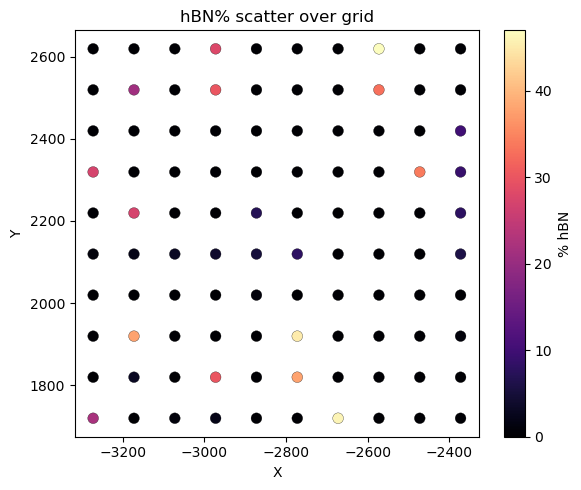

In [37]:
mg = pd.read_csv(os.path.join(out_dir, "grid_manifest.CSV"))

print("Counts:", mg["type"].value_counts().to_dict())
hbn_mixed = mg.loc[mg["type"]=="mixed","hbn_percent"]
if not hbn_mixed.empty:
    print("hBN% (mixed only) — min/median/max:",
          hbn_mixed.min(skipna=True), hbn_mixed.median(skipna=True), hbn_mixed.max(skipna=True))

# Coordinates
has_xy = ("X" in mg.columns) and ("Y" in mg.columns) and mg["X"].notna().all() and mg["Y"].notna().all()
if has_xy:
    x, y = mg["X"].values, mg["Y"].values
else:
    n = len(mg)
    side = int(np.ceil(np.sqrt(n)))
    r = (mg["index"].values - 1) // side
    c = (mg["index"].values - 1) %  side
    x, y = c, r

# Use recorded hBN% from manifest; pure PTFE rows already have 0
hbn_pct = mg["hbn_percent"].fillna(0).astype(float).values

# Visualization
plt.figure(figsize=(6,5))
sc = plt.scatter(x, y, c=hbn_pct, cmap="magma", s=60, edgecolor="k", linewidth=0.2)
plt.colorbar(sc, label="% hBN")
plt.title("hBN% scatter over grid")
plt.xlabel("X" if has_xy else "col"); plt.ylabel("Y" if has_xy else "row")
plt.tight_layout()
plt.show()


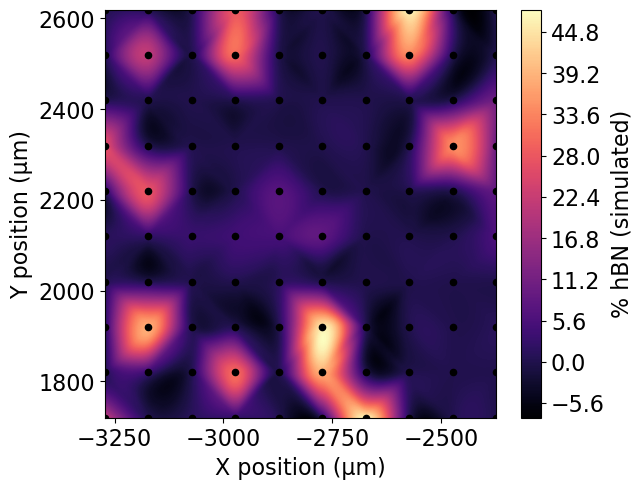

Saved: ../plots/fig1e.jpg


In [38]:
# Heatmap for manuscript
from scipy.interpolate import griddata
import numpy.ma as ma
from matplotlib.ticker import MaxNLocator

plot_dir = "../plots"                          
os.makedirs(plot_dir, exist_ok=True)

# Use x, y from earlier scatter setup
gx, gy = np.mgrid[min(x):max(x):200j, min(y):max(y):200j]
gz = griddata((x, y), hbn_pct, (gx, gy), method="cubic")
gz_mask = ma.masked_invalid(gz)

plt.figure(figsize=(6.5, 5))

# --- Heatmap with colormap ---
cs = plt.contourf(
    gx, gy, gz_mask,
    levels=300,
    cmap="magma"   # change to 'viridis', 'plasma', 'coolwarm', etc.
)

# --- Scatter overlay ---
plt.scatter(x, y, c="k", s=20)

# --- Colorbar with font control ---
cbar = plt.colorbar(cs)
cbar.set_label("% hBN (simulated)", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# --- Axis labels ---
plt.xlabel("X position (µm)", fontsize=16)
plt.ylabel("Y position (µm)", fontsize=16)

# --- Tick font sizes ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# --- Automatic tick interval (~5 ticks each axis) ---
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()

# --- Save figure ---
path_heat = os.path.join(plot_dir, "fig1e.jpg")
plt.savefig(path_heat, dpi=500)
plt.show()
print("Saved:", path_heat)

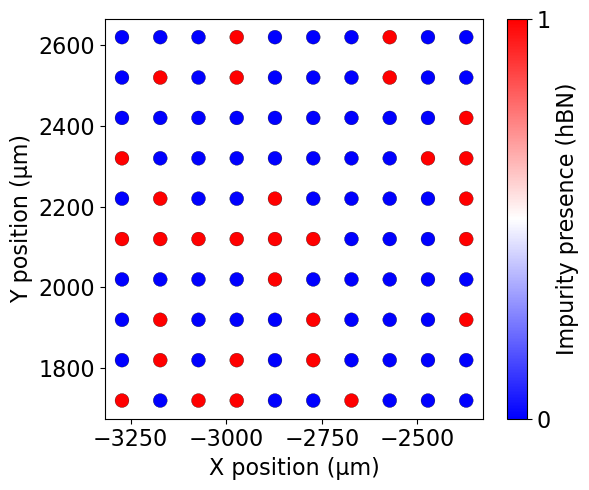

Saved: ../plots/fig1d.jpg


In [39]:
# === Load data and prepare coordinates ===
mg = pd.read_csv(os.path.join(out_dir, "grid_manifest.CSV"))
mg["binary_impurity"] = (mg["type"] == "mixed").astype(int)

has_xy = ("X" in mg.columns) and ("Y" in mg.columns)
if has_xy:
    x, y = mg["X"].values, mg["Y"].values
else:
    n = len(mg)
    side = int(np.ceil(np.sqrt(n)))
    r = (mg["index"].values - 1) // side
    c = (mg["index"].values - 1) % side
    x, y = c, r

plt.figure(figsize=(6, 5))

# --- Scatter plot with binary impurity colormap ---
sc = plt.scatter(
    x, y,
    c=mg["binary_impurity"],
    cmap="bwr",       # red/blue colormap
    s=100,
    edgecolor="k",
    linewidth=0.2
)

# --- Colorbar with font size ---
cbar = plt.colorbar(sc, ticks=[0, 1])
cbar.set_label("Impurity presence (hBN)", fontsize=16)
cbar.ax.tick_params(labelsize=16)

# --- Axis labels with font size ---
plt.xlabel("X position (µm)" if has_xy else "col", fontsize=16)
plt.ylabel("Y position (µm)" if has_xy else "row", fontsize=16)

# --- Tick font sizes ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# --- Automatic tick interval (~5 ticks each axis) ---
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# --- Save figure ---
plt.tight_layout()
path_bin = os.path.join(plot_dir, "fig1d.jpg")
plt.savefig(path_bin, dpi=500)
plt.show()
print("Saved:", path_bin)


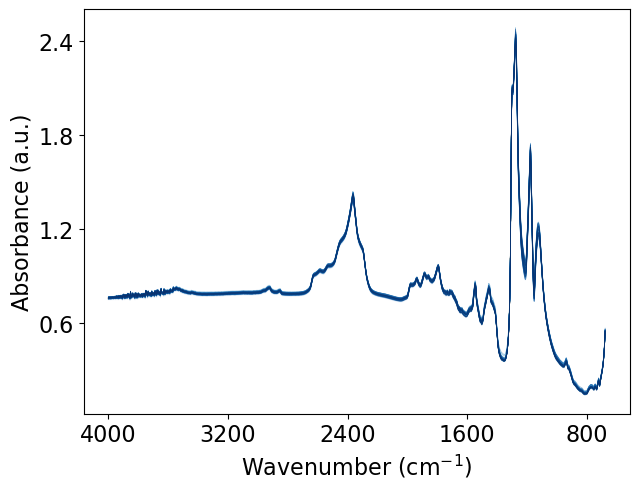

Saved: ../plots/fig1a.jpg
Plotted 100 PTFE spectra from '../data/raw/ptfe'.


In [40]:
# === Cell V1 — Plot all PTFE spectra (raw) ===
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
import os

def _load_xy_any(fn):
    try:
        df = pd.read_csv(fn, header=0)
        x = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        y = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        if np.isnan(x).any() or np.isnan(y).any():
            raise ValueError
    except Exception:
        df = pd.read_csv(fn, header=None)
        x = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy()
        y = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy()
        mask = ~(np.isnan(x) | np.isnan(y))
        x, y = x[mask], y[mask]
    return x, y

ptfe_files_vis = sorted(glob.glob(os.path.join(ptfe_raw_dir, "*.CSV"))) or \
                 sorted(glob.glob(os.path.join(ptfe_raw_dir, "*.csv")))
assert ptfe_files_vis, f"No CSV files found in {ptfe_raw_dir}"

# Visualization
plt.figure(figsize=(6.5, 5))

# --- Generate N colors from chosen colormap ---
colors = cm.Blues(np.linspace(0, 1, len(ptfe_files_vis)))  # change 'viridis' to other cmap names

for fn, c in zip(ptfe_files_vis, colors):
    x, y = _load_xy_any(fn)
    if x.size > 10000:  # optional downsample
        step = max(1, x.size // 10000)
        x, y = x[::step], y[::step]
    plt.plot(x, y, color=c, lw=0.5, alpha=0.5)

# --- Title and labels with font size ---
plt.xlabel("Wavenumber (cm$^{-1}$)", fontsize=16)
plt.ylabel("Absorbance (a.u.)", fontsize=16)

# --- Tick font sizes and ~5 ticks per axis ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# --- IR convention: invert X-axis ---
plt.gca().invert_xaxis()

plt.tight_layout()

# --- Save figure ---
path_spec1 = os.path.join(plot_dir, "fig1a.jpg")
plt.savefig(path_spec1, dpi=500)
plt.show()
print(f"Saved: {path_spec1}")
print(f"Plotted {len(ptfe_files_vis)} PTFE spectra from '{ptfe_raw_dir}'.")

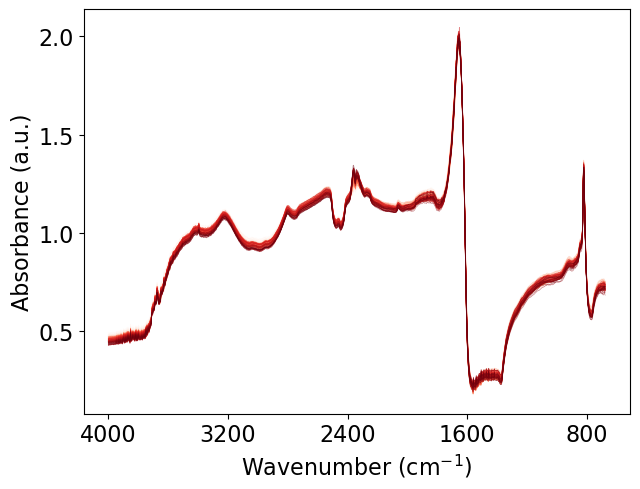

Saved: ../plots/fig1b.jpg
Plotted 100 hBN spectra from '../data/raw/hbn_thin'.


In [41]:
# === Cell V2 — Plot all hBN spectra (raw) ===
# --- Collect all hBN spectra files ---
hbn_files_vis = sorted(glob.glob(os.path.join(hbn_raw_dir, "*.CSV"))) or \
                sorted(glob.glob(os.path.join(hbn_raw_dir, "*.csv")))
assert hbn_files_vis, f"No CSV files found in {hbn_raw_dir}"

# --- Visualization ---
plt.figure(figsize=(6.5, 5))

# --- Generate N colors from chosen colormap ---
colors = cm.Reds(np.linspace(0, 1, len(hbn_files_vis)))  # change 'Reds' to other cmap names

for fn, c in zip(hbn_files_vis, colors):
    x, y = _load_xy_any(fn)  # reuse helper
    if x.size > 10000:  # optional downsample
        step = max(1, x.size // 10000)
        x, y = x[::step], y[::step]
    plt.plot(x, y, color=c, lw=0.5, alpha=0.5)

# --- Labels with font size ---
plt.xlabel("Wavenumber (cm$^{-1}$)", fontsize=16)
plt.ylabel("Absorbance (a.u.)", fontsize=16)

# --- Tick font sizes and ~5 ticks per axis ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# --- IR convention: invert X-axis ---
plt.gca().invert_xaxis()

plt.tight_layout()

# --- Save figure ---
path_spec2 = os.path.join(plot_dir, "fig1b.jpg")
plt.savefig(path_spec2, dpi=500)
plt.show()

print(f"Saved: {path_spec2}")
print(f"Plotted {len(hbn_files_vis)} hBN spectra from '{hbn_raw_dir}'.")


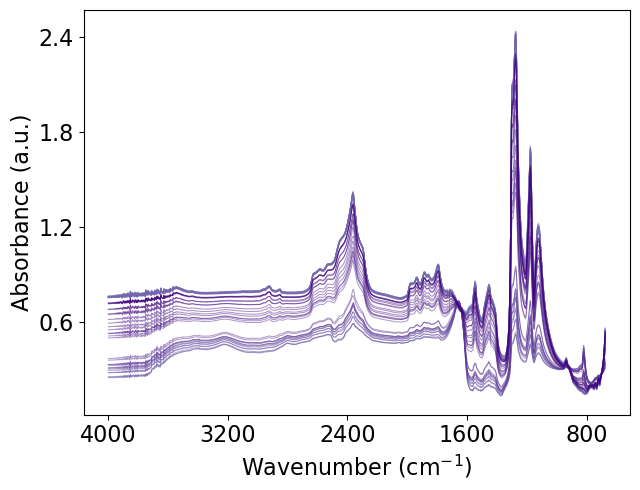

Saved: ../plots/fig1c.jpg
Plotted 101 generated spectra from '../generated/grid_100'.


In [42]:
# === Cell V3 — Plot all generated spectra (grid outputs) ===
# --- Collect all generated spectra files ---
gen_files = sorted(glob.glob(os.path.join(out_dir, "*.CSV"))) or \
            sorted(glob.glob(os.path.join(out_dir, "*.csv")))
assert gen_files, f"No generated CSV files found in {out_dir}"

def _load_generated(fn):
    df = pd.read_csv(fn)
    # compatible with either {'wn_cm-1','A'} or {'wn_cm-1','A_mix'}
    wn_col = "wn_cm-1" if "wn_cm-1" in df.columns else df.columns[0]
    a_col  = "A" if "A" in df.columns else ("A_mix" if "A_mix" in df.columns else df.columns[1])
    x = pd.to_numeric(df[wn_col], errors="coerce").to_numpy()
    y = pd.to_numeric(df[a_col],  errors="coerce").to_numpy()
    m = ~(np.isnan(x) | np.isnan(y))
    return x[m], y[m]

# --- Visualization ---
plt.figure(figsize=(6.5, 5))

# --- Generate N colors from chosen colormap ---
colors = cm.Purples(np.linspace(0, 1, len(gen_files)))  # change 'Purples' if needed

for fn, c in zip(gen_files, colors):
    x, y = _load_generated(fn)
    if x.size > 10000:  # optional downsample
        step = max(1, x.size // 10000)
        x, y = x[::step], y[::step]
    plt.plot(x, y, color=c, lw=0.7, alpha=0.5)

# --- Labels with font size ---
plt.xlabel("Wavenumber (cm$^{-1}$)", fontsize=16)
plt.ylabel("Absorbance (a.u.)", fontsize=16)

# --- Tick font sizes and ~5 ticks per axis ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# --- IR convention: invert X-axis ---
plt.gca().invert_xaxis()

plt.tight_layout()

# --- Save figure ---
path_spec3 = os.path.join(plot_dir, "fig1c.jpg")
plt.savefig(path_spec3, dpi=500)
plt.show()

print(f"Saved: {path_spec3}")
print(f"Plotted {len(gen_files)} generated spectra from '{out_dir}'.")
